# Análisis de Crímenes 2024

Este notebook contiene el análisis exploratorio de datos sobre crímenes reportados en 2024.

## Importación de Librerías

Importamos las bibliotecas necesarias para el análisis de datos:

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


sns.set_theme(style='whitegrid')

df = pd.read_csv('lib/Crimes_-_2024_20251122.csv', low_memory=False)


print("Primeras 5 filas del dataset:")
display(df.head())
print('Data shape (filas, columnas)',df.shape)

print("Data types", df.dtypes)

columns = df.columns.tolist()
print("columns", columns)

Primeras 5 filas del dataset:


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13709672,JJ101940,12/31/2024 11:58:00 PM,014XX E 68TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,332,3,5,43,14,1186817.0,1860189.0,2024,11/02/2025 03:41:09 PM,41.771470,-87.590742,POINT (-87.59074212 41.771470188)
1,13707925,JJ100089,12/31/2024 11:56:00 PM,047XX S DR MARTIN LUTHER KING JR DR,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,True,True,223,2,3,38,26,1179661.0,1873623.0,2024,05/17/2025 03:40:52 PM,41.808501,-87.616563,POINT (-87.616562762 41.808500903)
2,13708038,JJ100035,12/31/2024 11:55:00 PM,077XX S CICERO AVE,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,False,True,834,8,18,70,04B,1145740.0,1853048.0,2024,11/02/2025 03:41:09 PM,41.752749,-87.741498,POINT (-87.741497836 41.752748627)
3,13709164,JJ101392,12/31/2024 11:53:00 PM,066XX S GREENWOOD AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,321,3,20,42,14,1184362.0,1861188.0,2024,11/02/2025 03:41:09 PM,41.774269,-87.599710,POINT (-87.599709962 41.774269351)
4,13707823,JJ100020,12/31/2024 11:50:00 PM,012XX N MENARD AVE,0460,BATTERY,SIMPLE,SIDEWALK,False,False,2531,25,29,25,08B,1137458.0,1907694.0,2024,05/17/2025 03:40:52 PM,41.902858,-87.770537,POINT (-87.770536741 41.902858242)


Data shape (filas, columnas) (258829, 22)
Data types ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                      int64
Community Area            int64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object
columns ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year',

## Análisis de Tipos de Datos

A continuación se muestra una tabla detallada de los tipos de datos para cada columna del dataset:

In [8]:
# Tabla simple: id (nombre de la columna) y tipo_de_dato (dtype)
tipos_tabla = pd.DataFrame({
    'id': df.columns.tolist(),
    'tipo_de_dato': [str(df[col].dtype) for col in df.columns]
})

print("\nTabla con id y tipo de dato:")
display(tipos_tabla)


Tabla con id y tipo de dato:


,id,tipo_de_dato
0,ID,int64
1,Case Number,object
2,Date,object
3,Block,object
4,IUCR,object
5,Primary Type,object
6,Description,object
7,Location Description,object
8,Arrest,bool
9,Domestic,bool


# Interpretación de variables

| Nombre de columna | Descripción | Tipo de dato (Database) | Tipo de variable (Clasificación) |
|-------------------|-------------|-------------------------|------------------------------|
| ID | Identificador único del registro | Number | Categórica |
| Case Number | El número RD(Record Division Number) del departamento de policía de Chicago | Text | Categórica |
| Date | Fecha en la que ocurrió el incidente. A veces es estimada | Timestamp | Fecha |
| Block | La dirección parcialmente redactada donde ocurrió el incidente, colocándola en la misma cuadra que la dirección real. | Text | Categórica nominal |
| IUCR | El código de Reporte Uniforme de Delitos de Illinois. Esto está directamente vinculado con Primary Type y Description. Consulte la lista de códigos IUCR en https://data.cityofchicago.org/d/c7ck-438e. | Text | Categórica nominal |
| Primary Type | La descripción primaria del código IUCR | Text | Categórica nominal |
| Description | La descripción secundaria del código IUCR, una subcategoría de la descripción primaria. | Text | Categórica nominal |
| Location Description | Descripción de la ubicación en donde ocurrió el incidente | Text | Categórica nominal |
| Arrest | Indica si se hizo un arresto. | Checkbox | Categórica nominal |
| Domestic | Indica si el incidente estuvo relacionado con violencia doméstica según lo definido por la Ley de Violencia Doméstica de Illinois. | Checkbox | Categórica nominal |
| Beat | Indica el sector donde ocurrió el incidente. Un sector es la zona geográfica más pequeña de la policía: cada sector tiene un coche de policía dedicado. De tres a cinco sectores conforman un distrito policial y tres distritos forman un distrito de policía. El Departamento de Policía de Chicago tiene 22 distritos policiales. Vea los sectores en https://data.cityofchicago.org/d/aerh-rz74. | Text | Categórica nominal |
| District | Indica el distrito policial donde ocurrió el incidente. Consulte los distritos en https://data.cityofchicago.org/d/fthy-xz3r. | Text | Categórica nominal |
| Ward | El distrito (distrito del Ayuntamiento) donde ocurrió el incidente. Vea los distritos en https://data.cityofchicago.org/d/sp34-6z76. | Text | Categórica nominal |
| Community Area | Indica el área comunitaria donde ocurrió el incidente. Chicago tiene 77 áreas comunitarias. Vea las áreas comunitarias en https://data.cityofchicago.org/d/cauq-8yn6. | Text | Categórica nominal |
| FBI Code | Indica la clasificación del delito según lo establecido en el Sistema Nacional de Informes Basado en Incidentes (NIBRS) del FBI. Consulte el listado de estas clasificaciones del Departamento de Policía de Chicago en https://gis.chicagopolice.org/pages/crime_details. | Text | Categórica nominal |
| X Coordinate | La coordenada X del lugar donde ocurrió el incidente en la proyección State Plane Illinois East NAD 1983. Esta ubicación se ha desplazado del lugar real por motivos de redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Y Coordinate | La coordenada Y del lugar donde ocurrió el incidente en la proyección State Plane Illinois East NAD 1983. Esta ubicación se ha desplazado del lugar real por motivos de redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Year | Año en el que ocurrió el incidente. | Number | Numérica discreta |
| Updated On | Día y hora en los que el registro se actualizó por última vez. | Timestamp | Fecha |
| Latitude | La latitud del lugar donde ocurrió el incidente. Esta ubicación se ha desplazado respecto a la ubicación real para una redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Longitude | La longitud del lugar donde ocurrió el incidente. Esta ubicación se ha desplazado respecto a la ubicación real para una redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Location | La ubicación donde ocurrió el incidente en un formato que permite la creación de mapas y otras operaciones geográficas en este portal de datos. Esta ubicación está desplazada respecto a la ubicación real para una redacción parcial, pero se encuentra en la misma manzana. | Point | Categórica |

Prácticamente, todas las variables son categóricas, sin embargo podrían considerarse ocasionalmente numéricas aquellas de ubicación por coordenadas y de fechas. Pueden agruparse las variables por el tipo de información que brindan:
- Identificación: ID, Case Number
- Fechas: Date, Year, Updated On
- Ubicación: Latitude, Longitude, X Coordinate, Y Coordinate, Beat, Community Area, District, Ward, Block, Location
- Clasificación: Primary Type, Description, Location Description, IUCR, FBI Code
- Situación legal: Arrest (True/False), Domestic (True/False)


### Crímenes agrupados por tiempo/fechas

In [9]:
df['Date_raw'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

df['Month'] = df['Date_raw'].dt.month

df['Day'] = df['Date_raw'].dt.dayofyear

df['Hour'] = df['Date_raw'].dt.hour

df['WeekDay'] = df['Date_raw'].dt.day_name()

print(f"Se verifica si quedó alguna fila sin parsear: {df['Date_raw'].isna().sum()}")

Se verifica si quedó alguna fila sin parsear: 0


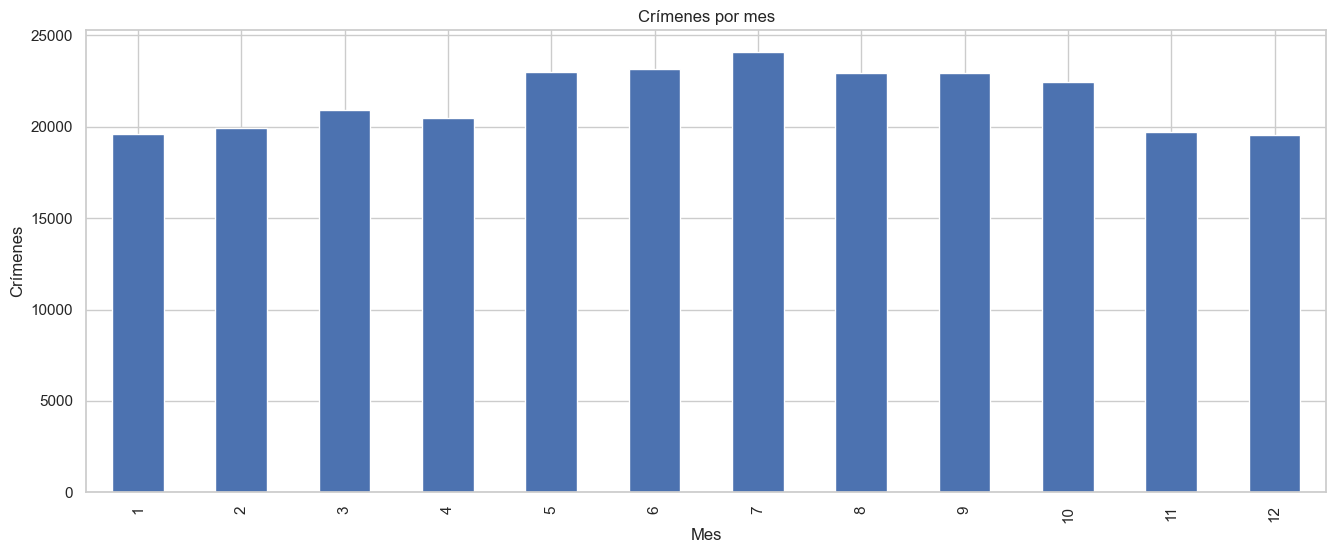

In [10]:
df['Month'].value_counts().sort_index().plot(kind='bar', title='Crímenes por mes', figsize=(16, 6))
plt.xlabel('Mes')
plt.ylabel('Crímenes')
plt.show()

Se puede observar un aumento de los crímenes hacia los mese más calurosos del año o, visto al revés, un descenso hacia los meses más fríos.

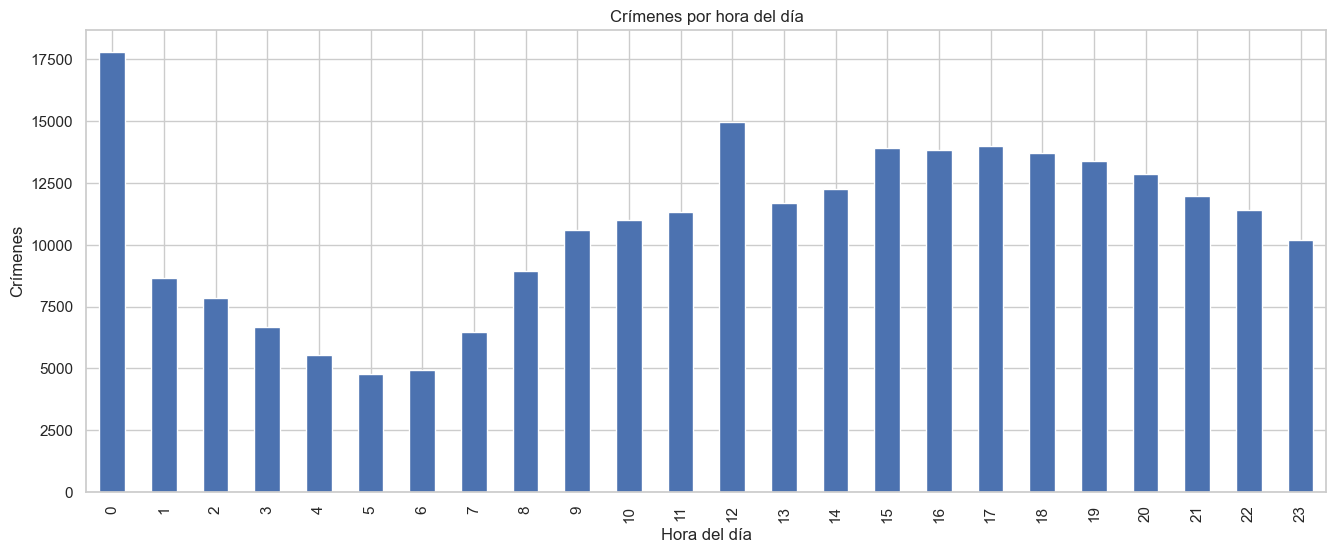

In [11]:
df['Hour'].value_counts().sort_index().plot(kind='bar', title='Crímenes por hora del día', figsize=(16, 6))
plt.xlabel('Hora del día')
plt.ylabel('Crímenes')
plt.show()

Se puede observar casi una curva suave a medida que se avanza en horas, salvo por dos picos a las 00hs y 12 hs (En 24hs), probablemente debido cómo se registran los delitos con horarios no conocidos con precisión según el turno.
Descartando estos picos, se ve una disminución hacia las 5hs y 6hs (madrugada) y un aumento en el rango de 15hs a 18hs.

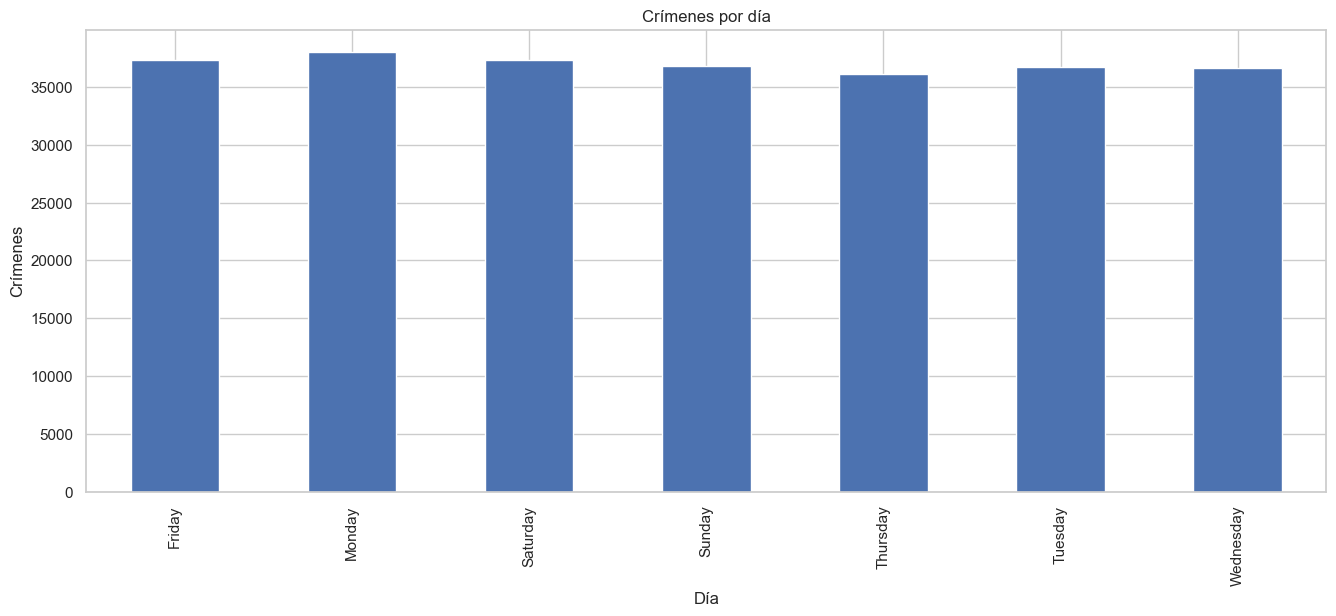

In [12]:
df['WeekDay'].value_counts().sort_index().plot(kind='bar', title='Crímenes por día', figsize=(16, 6))
plt.xlabel('Día')
plt.ylabel('Crímenes')
plt.show()

No se ve una diferencia notable entre cada día de la semana.

In [13]:
import calendar
import locale

# Configurar locale para nombres de meses en español
locale.setlocale(locale.LC_ALL, 'es_ES')
nombres_meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 
                5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto',
                9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}

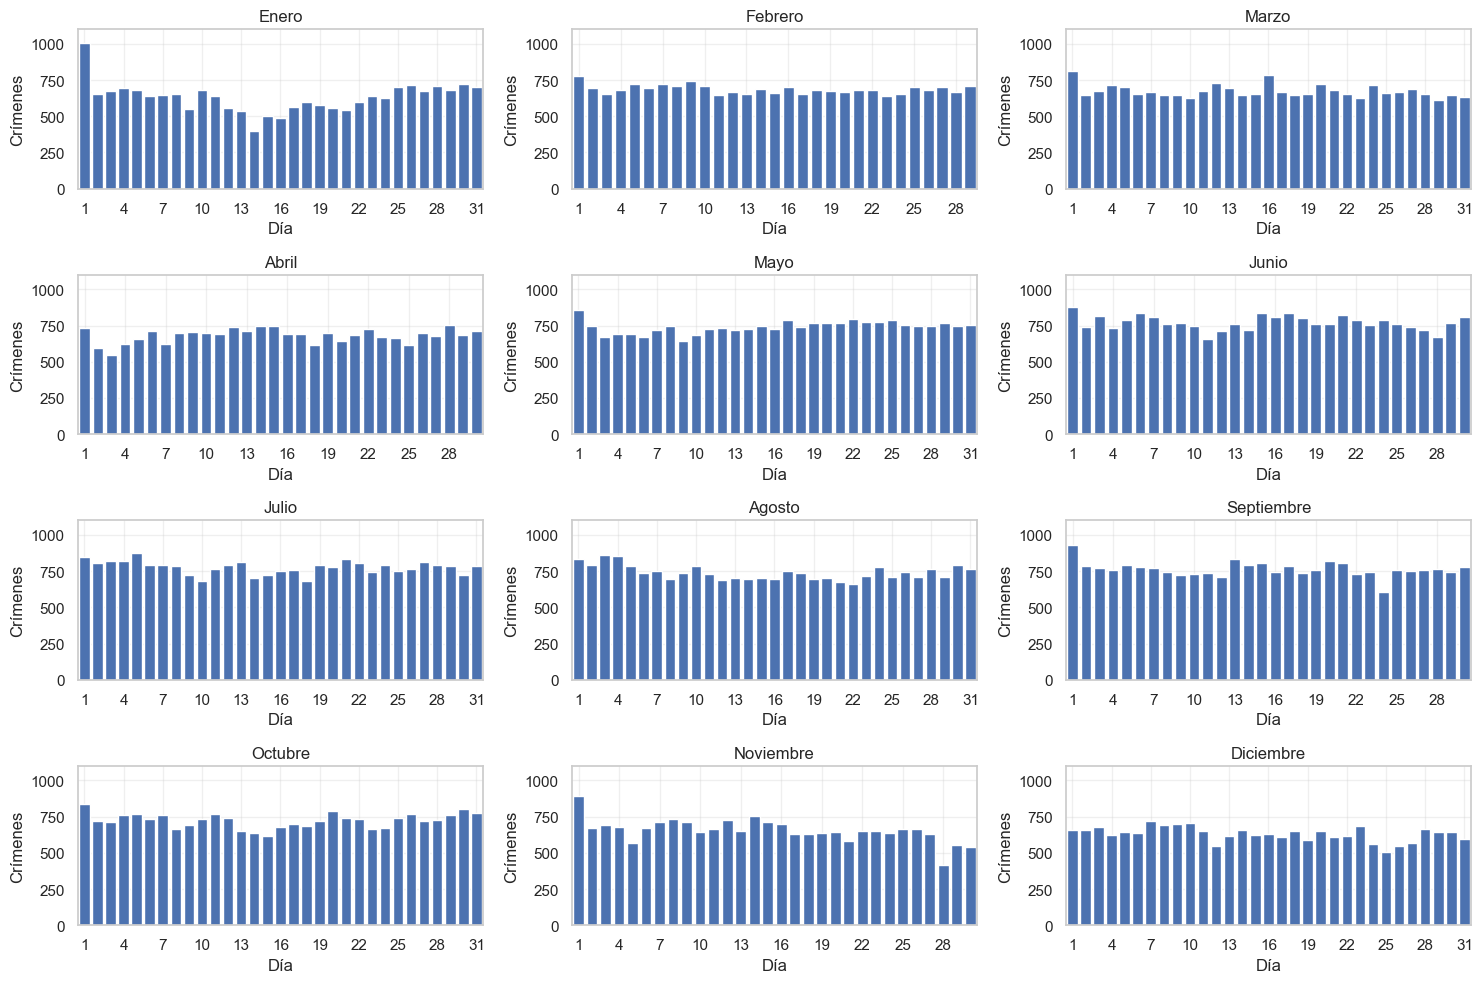

In [14]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.flatten()

max_y = 1100
for i, mes in enumerate(sorted(df['Month'].unique()), 0):
    datos_mes = df[df['Month'] == mes]

    ultimo_dia = calendar.monthrange(2024, mes)[1]
    dias_mes = np.arange(1, ultimo_dia + 1)

    # Contar crímenes por día y rellenar días faltantes con 0
    conteo = datos_mes.groupby(datos_mes['Date_raw'].dt.day).size()
    conteo = conteo.reindex(dias_mes, fill_value=0)

    axs[i].bar(dias_mes, conteo.values)
    axs[i].set_title(nombres_meses[mes])
    axs[i].set_xlabel("Día")
    axs[i].set_ylabel("Crímenes")

    axs[i].set_xlim(0.5, ultimo_dia + 0.5)  # Ajustar límites
    axs[i].set_xticks(range(1, ultimo_dia + 1, 3))  # Ticks cada 5 días
    axs[i].set_ylim(0, max_y)
    axs[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

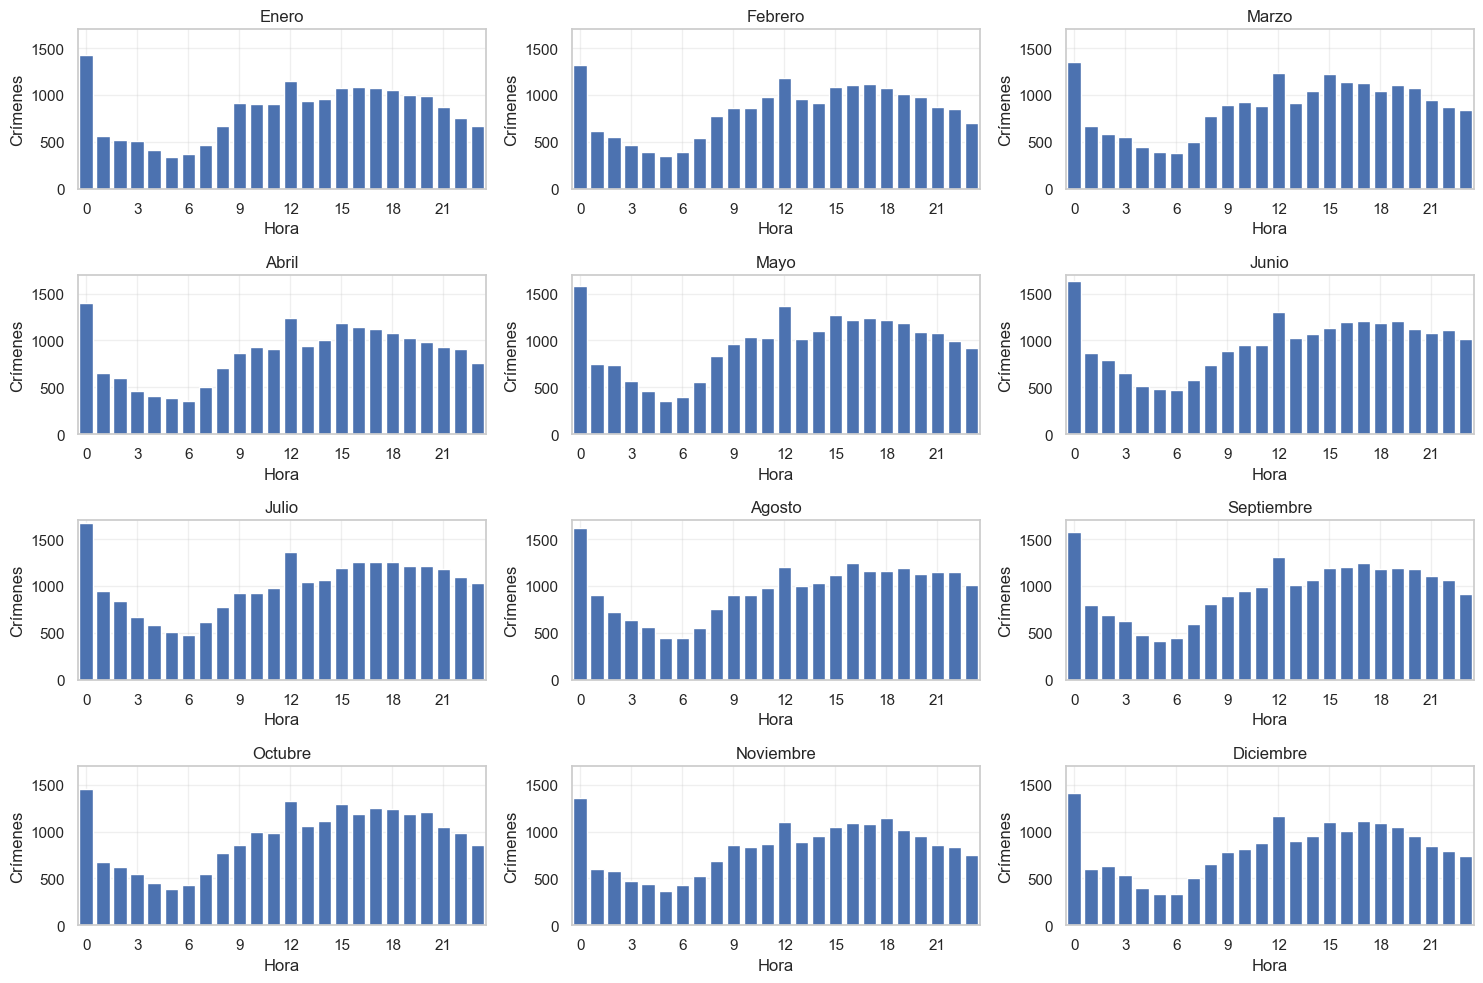

In [15]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.flatten()

max_y = 1700
for i, mes in enumerate(sorted(df['Month'].unique()), 0):
    datos_mes_h = df[df['Month'] == mes]

    # Contar crímenes por hora y rellenar horas faltantes con 0
    horas = np.arange(0, 24)
    conteo = datos_mes_h.groupby(datos_mes_h['Date_raw'].dt.hour).size()
    conteo = conteo.reindex(horas, fill_value=0)

    axs[i].bar(horas, conteo.values)
    axs[i].set_title(nombres_meses[mes])
    axs[i].set_xlabel("Hora")
    axs[i].set_ylabel("Crímenes")

    axs[i].set_xlim(-0.5, 23.5)
    axs[i].set_xticks(range(0, 24, 3))
    axs[i].set_ylim(0, max_y)
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Crímenes agrupados por ubicación/espacio

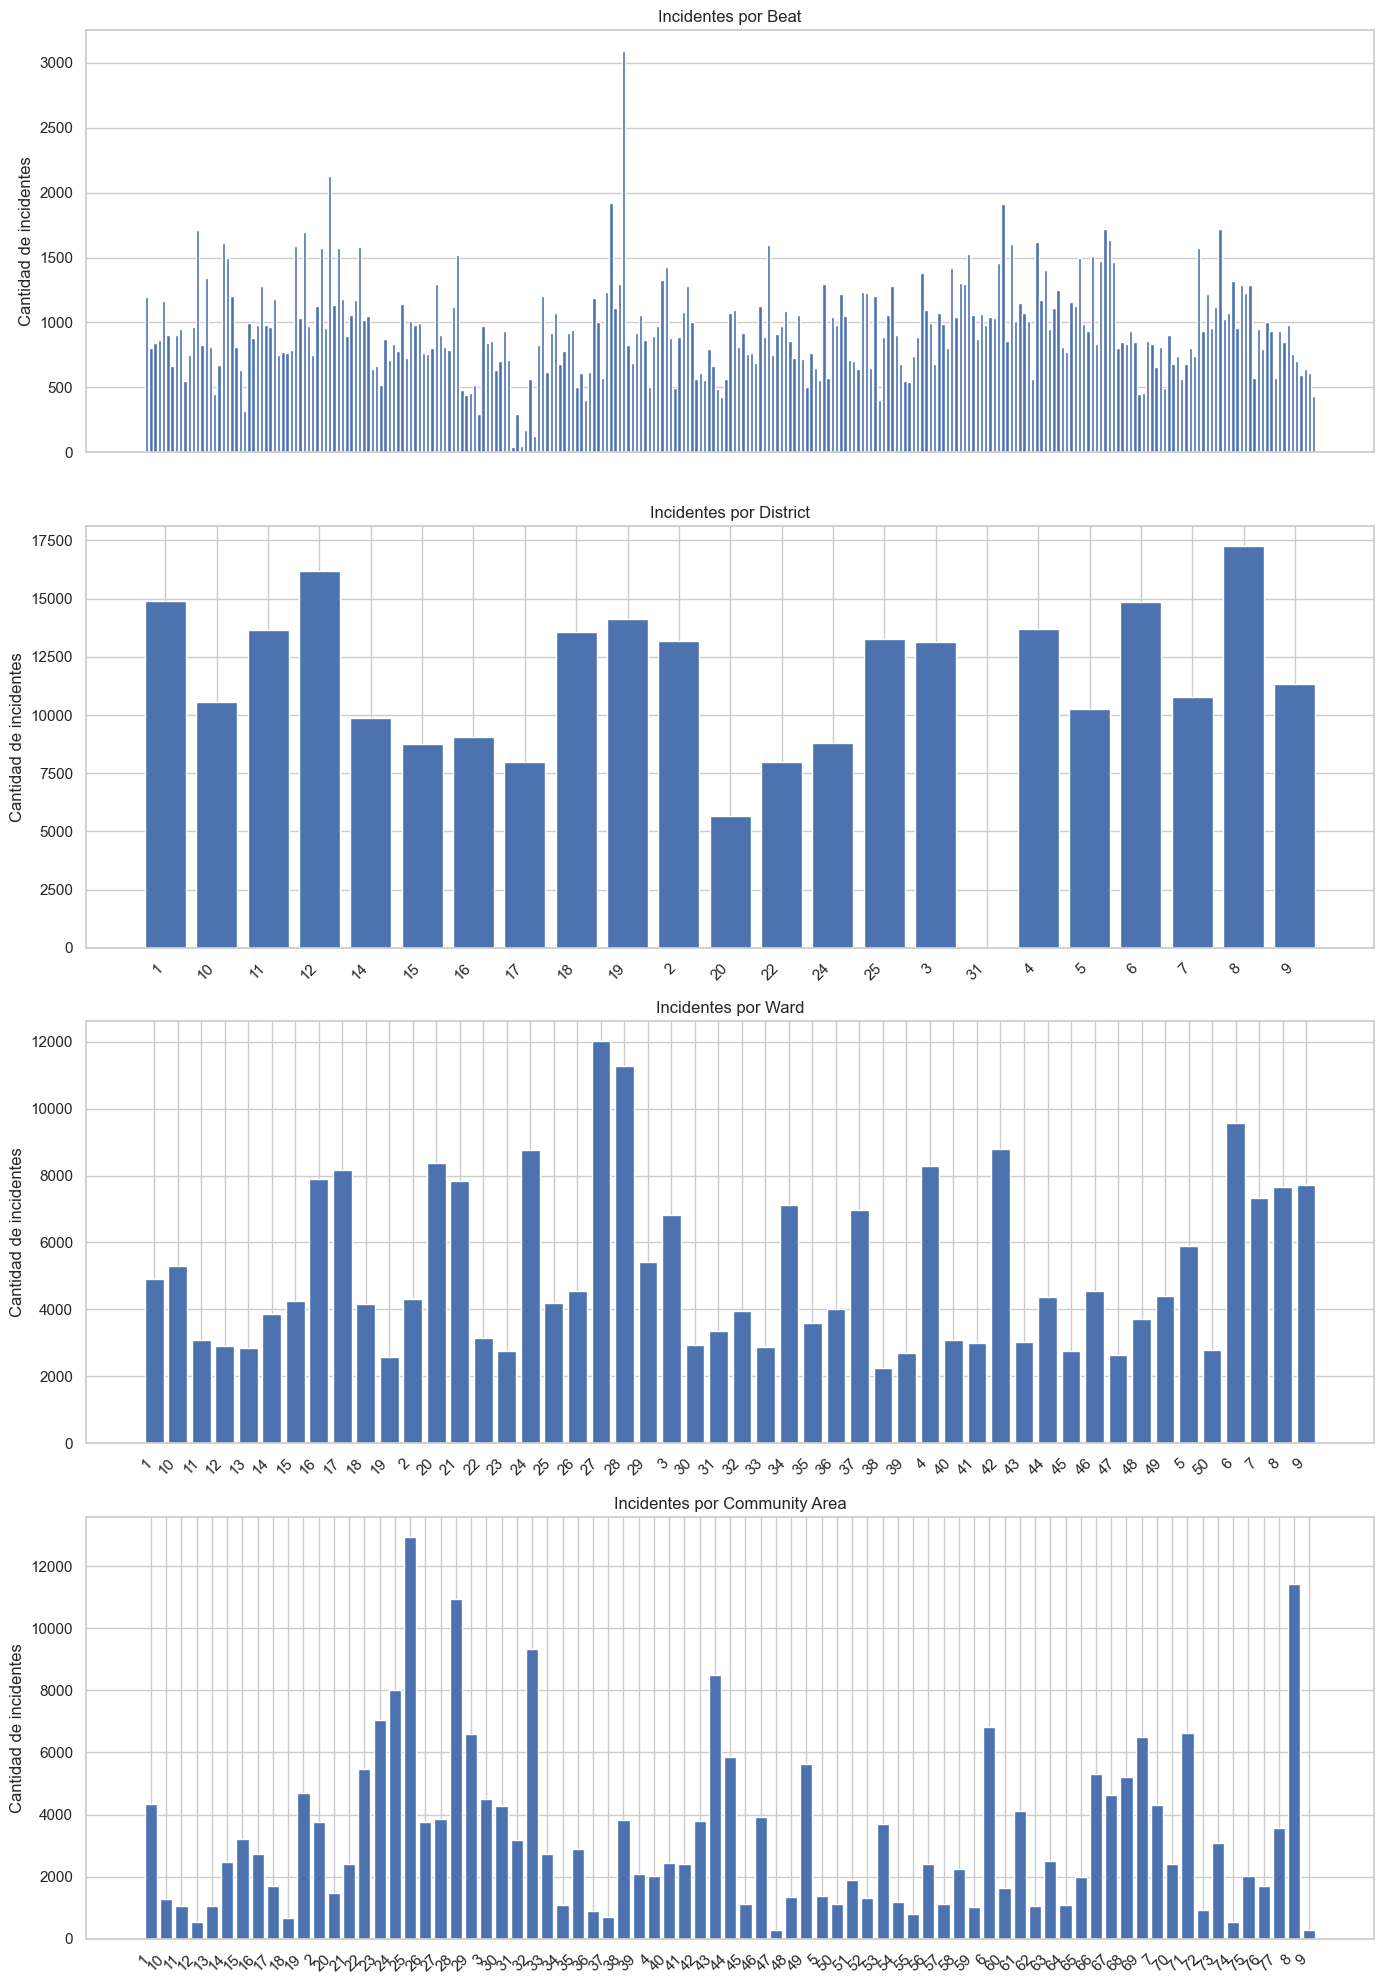

In [16]:
cols = ['Beat', 'District', 'Ward', 'Community Area']

fig, axs = plt.subplots(len(cols), 1, figsize=(14, 5 * len(cols)))
for ax, col in zip(axs, cols):
    vc = df[col].dropna().astype(str).value_counts().sort_index()
    ax.bar(vc.index, vc.values)
    if col == 'Beat':
        ax.set_xticks([])
    else:
        ax.set_xticks(range(len(vc.index)))
        ax.set_xticklabels(vc.index, rotation=45, ha='right')
    
    ax.set_ylabel('Cantidad de incidentes')
    ax.set_title(f'Incidentes por {col}')
    
plt.tight_layout()
plt.show()

In [112]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt


# Opciones para mejor visualización
pd.set_option('display.max_columns', None)

In [113]:
beats = gpd.read_file('lib/PoliceBeatDec2012_20251123.csv')  # o el nombre real de tu archivo
# Si el CSV tiene la columna “the_geom” en formato WKT o similar,
# podrías necesitar convertirla manualmente a geometría, ej:

beats['geometry'] = beats['the_geom'].apply(wkt.loads)
beats = gpd.GeoDataFrame(beats, geometry='geometry')
beats.head()
beats.crs  # comprobar sistema de coordenadas

# Normalizar nombres de columna
beats['BEAT_NUM'] = beats['BEAT_NUM'].astype(str).str.zfill(4)
df['BEAT'] = df['Beat'].astype(int).astype(str).str.zfill(4)

# Agrupar
counts = df.groupby('BEAT').size().reset_index(name='crime_count')

# Unir con los polígonos
beats = beats.astype({'BEAT_NUM': str})  # asegurar que coincidan tipos
beats = beats.merge(counts, left_on='BEAT_NUM', right_on='BEAT', how='left')

# Los beats sin crímenes tendrán NaN -> convertir a 0
beats['crime_count'] = beats['crime_count'].fillna(0)
beats['crime_count'] = beats['crime_count'].astype('int64')


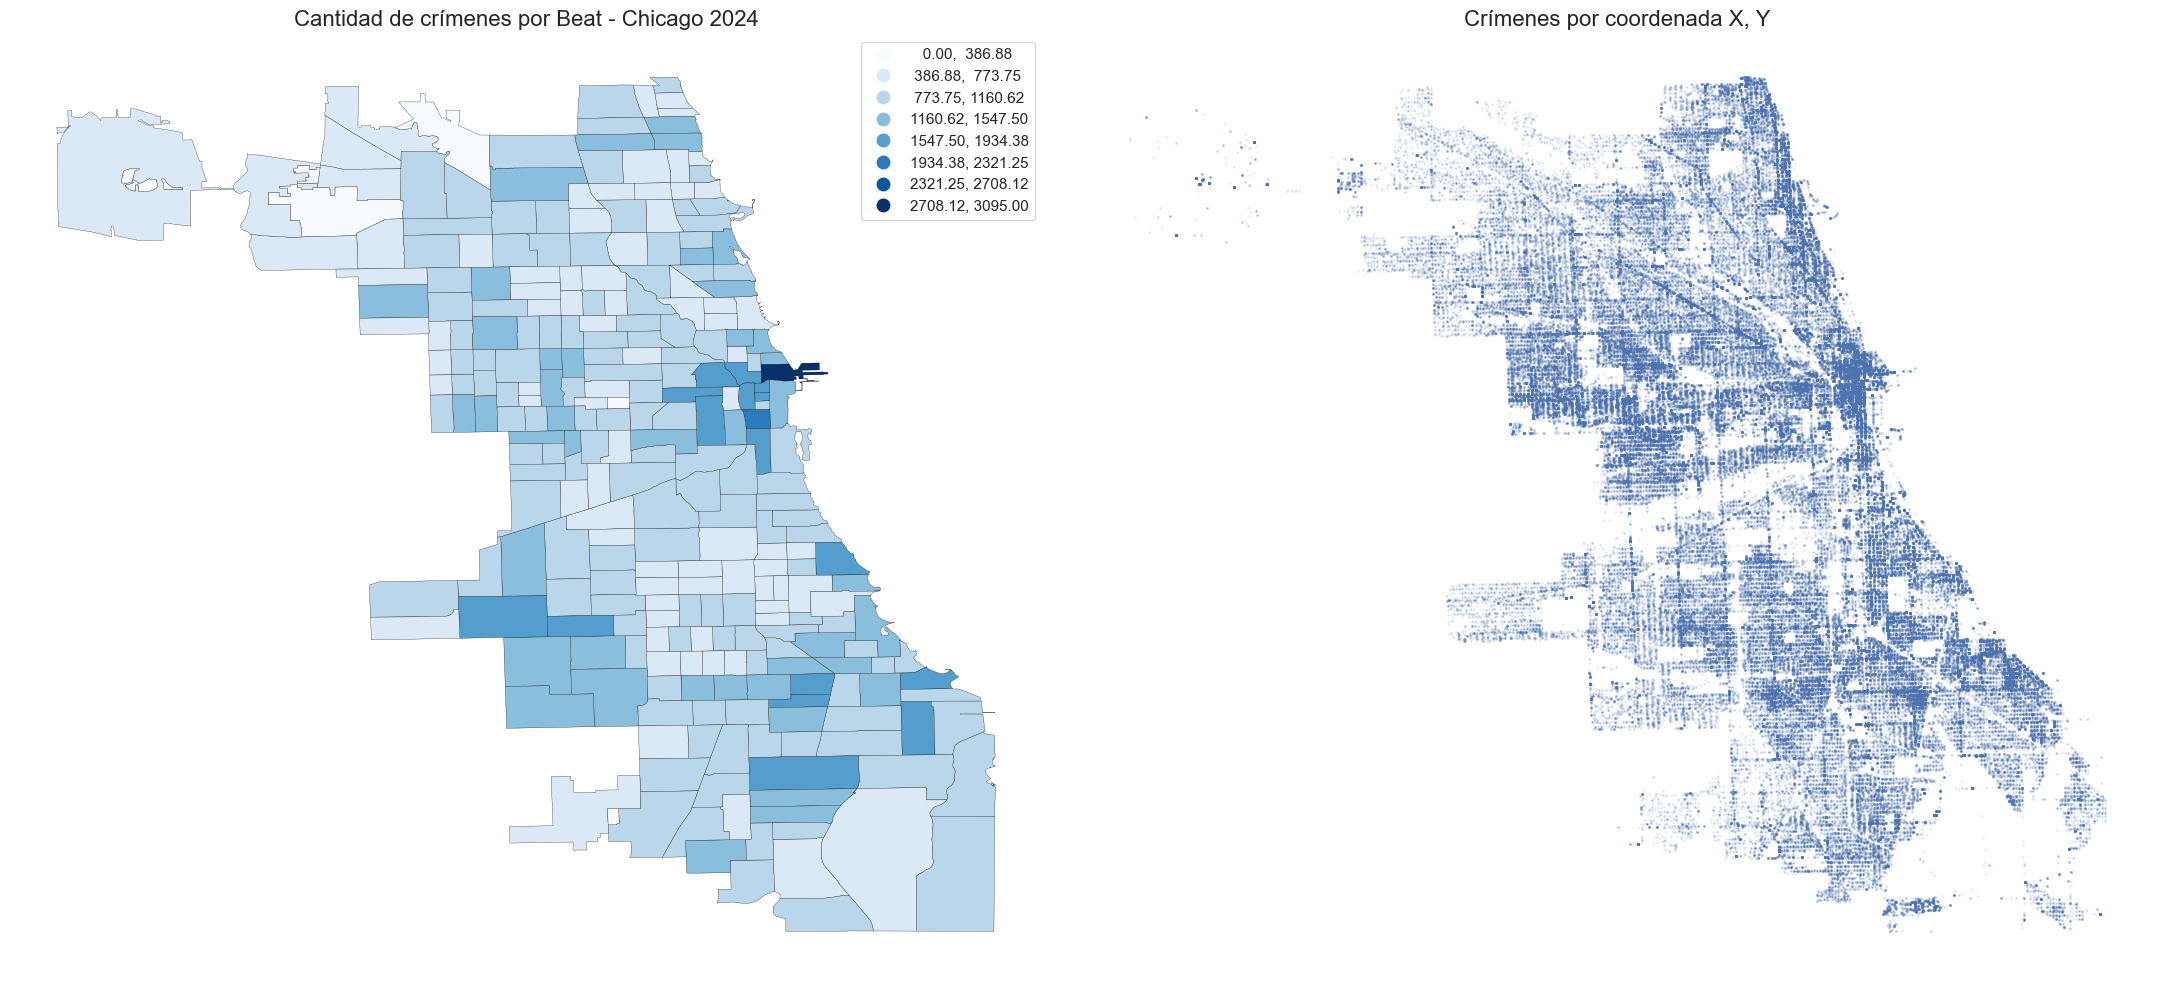

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
# plt.figure(figsize=(12, 10))
beats.plot(column='crime_count',
           cmap='Blues',     # mapa de colores — naranja-rojo
           scheme='equal_interval',  # o 'naturalbreaks', 'equal_interval', 'quantiles
           k=8,
           legend=True,
           edgecolor='black',
           linewidth=0.2,
           ax=ax[0])
ax[0].set_title('Cantidad de crímenes por Beat - Chicago 2024', fontsize=16)
ax[0].axis('off')

ax[1].scatter(df['X Coordinate'], df['Y Coordinate'], 
           alpha=0.1,  # Transparencia para ver densidad
           s=1)

ax[1].set_title('Crímenes por coordenada X, Y', fontsize=16)
ax[1].axis('off')


plt.tight_layout()
plt.show()


### Crímenes agrupados por clasificación

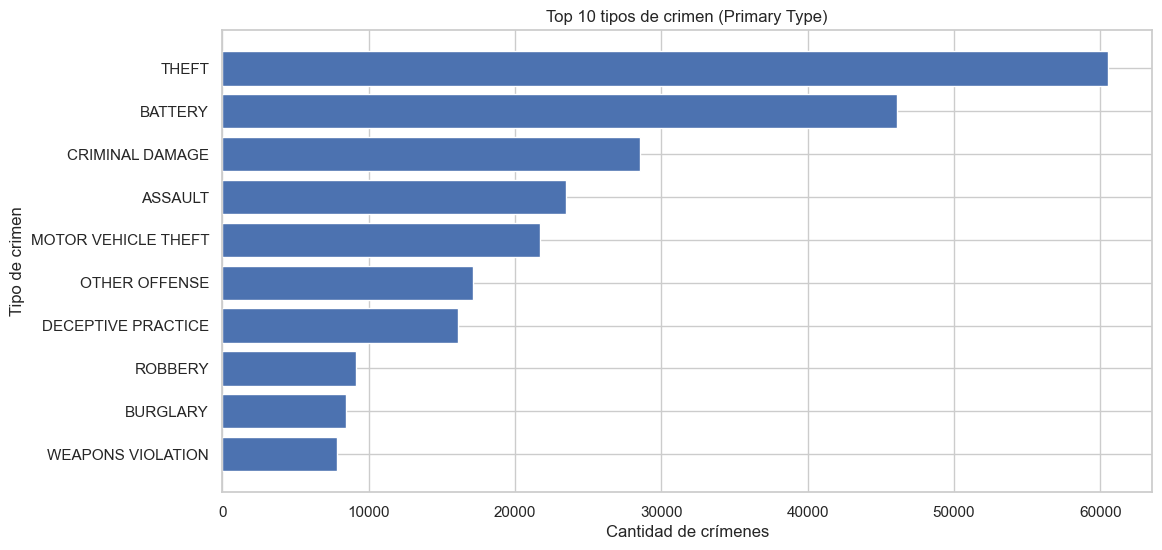

In [73]:
# Crímenes más frecuentes por tipo
top_primary = df['Primary Type'].value_counts().nlargest(10)

plt.figure(figsize=(12,6))
plt.barh(top_primary.index[::-1], top_primary.values[::-1])
# sns.barplot(x=top_primary.values, y=top_primary.index)
plt.title("Top 10 tipos de crimen (Primary Type)")
plt.xlabel("Cantidad de crímenes")
plt.ylabel("Tipo de crimen")
plt.show()

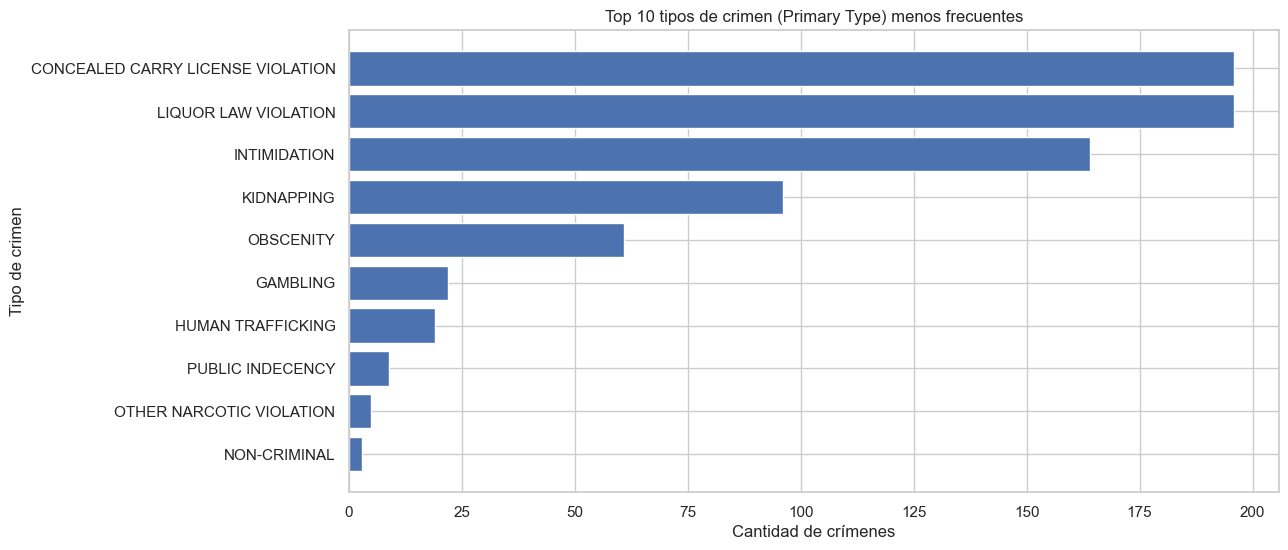

In [69]:
# Crímenes más frecuentes por tipo
bot_primary = df['Primary Type'].value_counts().nsmallest(10)

plt.figure(figsize=(12,6))
plt.barh(bot_primary.index, bot_primary.values)
plt.title("Top 10 tipos de crimen (Primary Type) menos frecuentes")
plt.xlabel("Cantidad de crímenes")
plt.ylabel("Tipo de crimen")
plt.show()


El "Primary Type" del crimen viene ampliado por la variable "Description", es decir que le aporta algo más de detalle. Es una variable categórica cuyos posibles valores dependen del valor del mismo registro en la columna Primary Type. Se observan 319 valores únicos para esta columna, por lo cual se analiza filtrando para unas pocas alternativas (Top 5) de Primary Type pero sirve para entenderlo de manera general.

In [78]:
top5_types = df['Primary Type'].value_counts().nlargest(5).index
df_top5 = df[df['Primary Type'].isin(top5_types)]

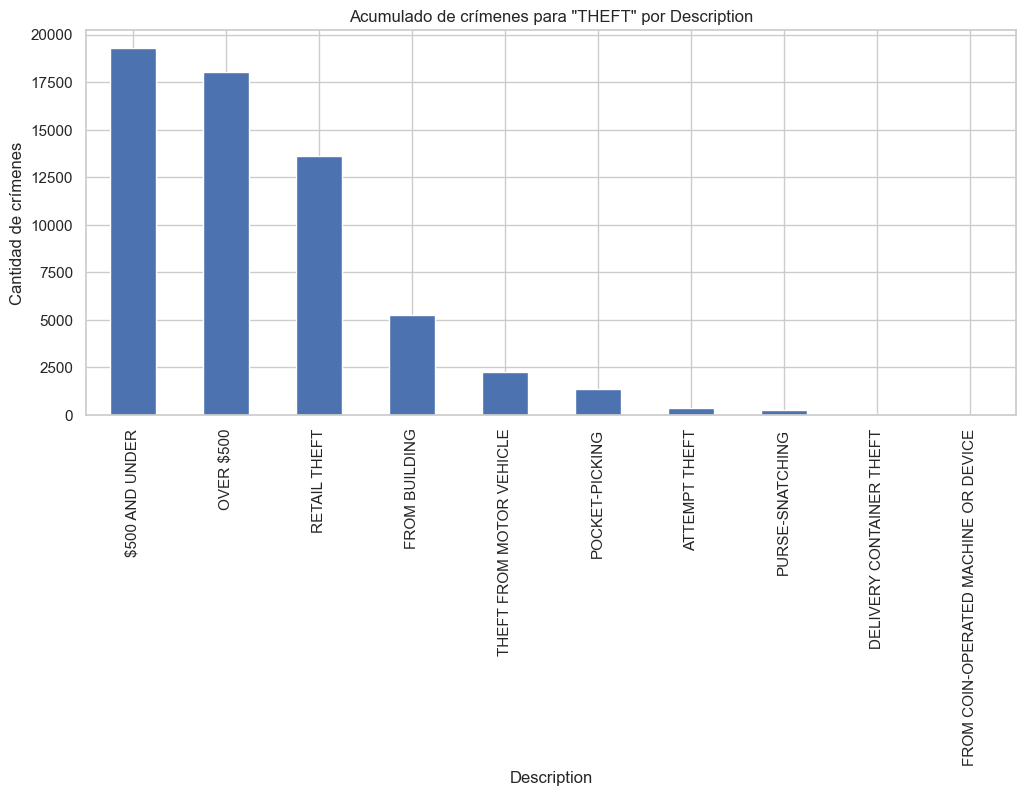


Crímenes con Descritpion para 'THEFT':
Description
$500 AND UNDER                          19271
OVER $500                               18039
RETAIL THEFT                            13627
FROM BUILDING                            5257
THEFT FROM MOTOR VEHICLE                 2283
POCKET-PICKING                           1354
ATTEMPT THEFT                             377
PURSE-SNATCHING                           263
DELIVERY CONTAINER THEFT                   38
FROM COIN-OPERATED MACHINE OR DEVICE       14
Name: count, dtype: int64


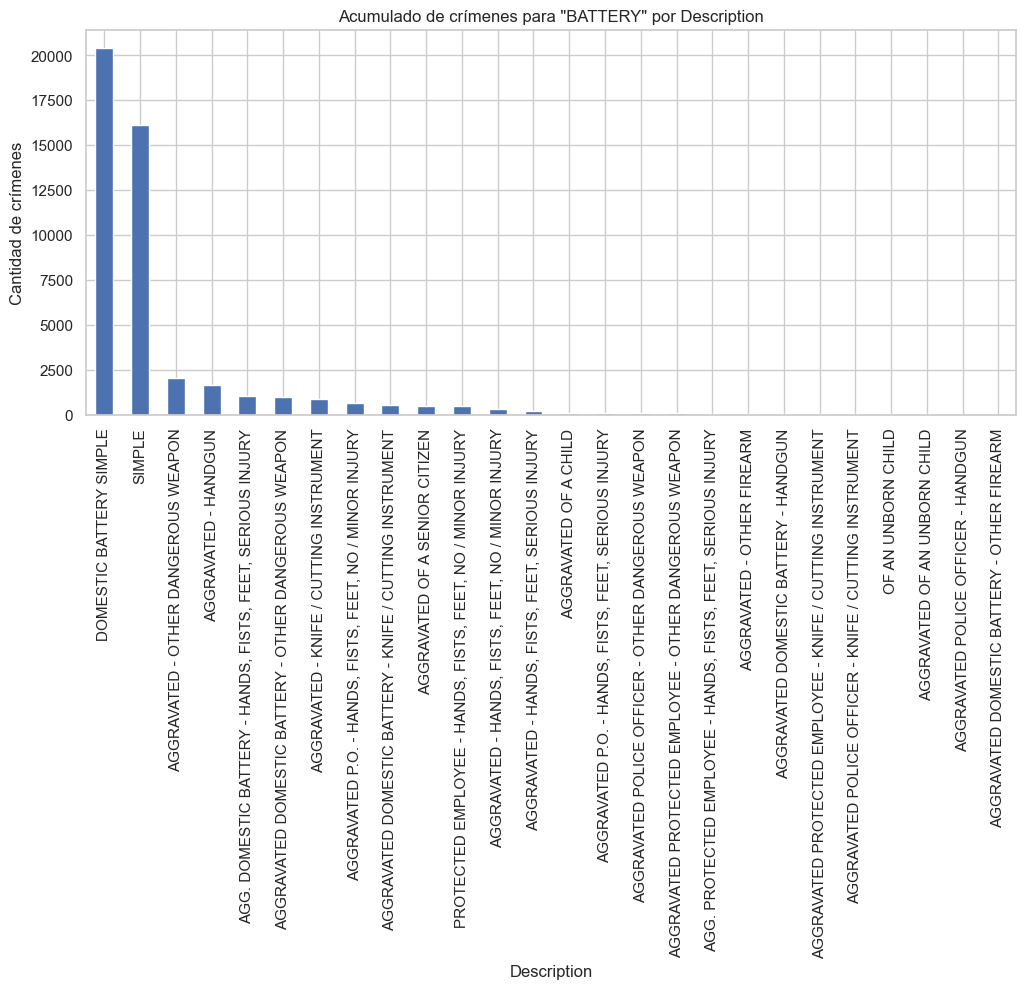


Crímenes con Descritpion para 'BATTERY':
Description
DOMESTIC BATTERY SIMPLE                                         20408
SIMPLE                                                          16095
AGGRAVATED - OTHER DANGEROUS WEAPON                              2023
AGGRAVATED - HANDGUN                                             1660
AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY       1006
AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS WEAPON              976
AGGRAVATED - KNIFE / CUTTING INSTRUMENT                           872
AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MINOR INJURY           667
AGGRAVATED DOMESTIC BATTERY - KNIFE / CUTTING INSTRUMENT          533
AGGRAVATED OF A SENIOR CITIZEN                                    502
PROTECTED EMPLOYEE - HANDS, FISTS, FEET, NO / MINOR INJURY        493
AGGRAVATED - HANDS, FISTS, FEET, NO / MINOR INJURY                285
AGGRAVATED - HANDS, FISTS, FEET, SERIOUS INJURY                   189
AGGRAVATED OF A CHILD               

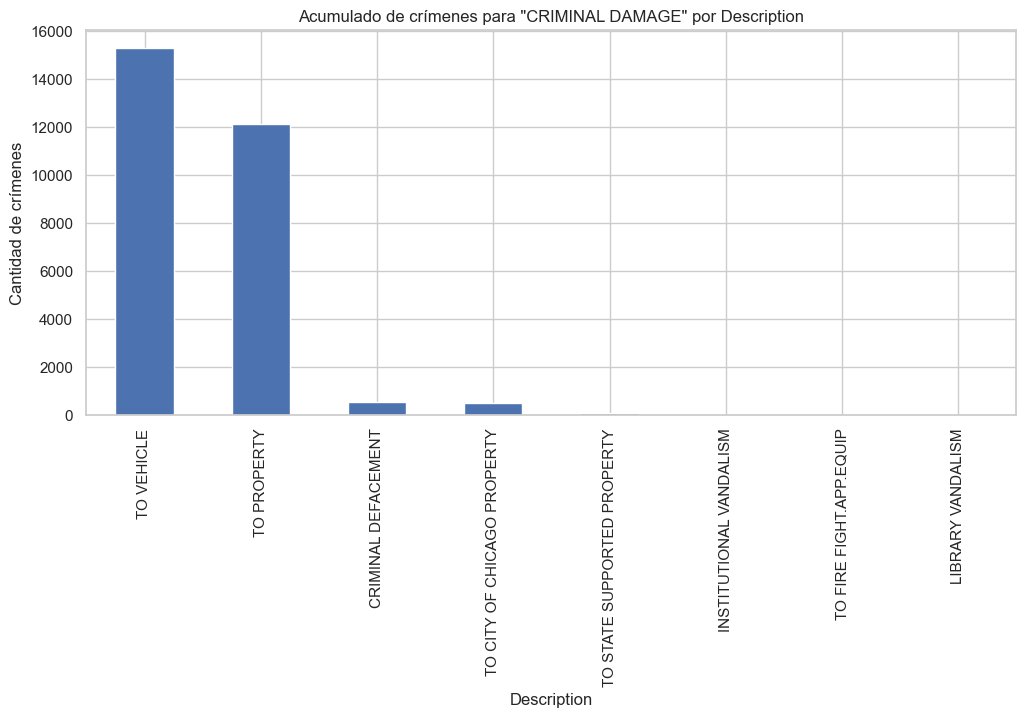


Crímenes con Descritpion para 'CRIMINAL DAMAGE':
Description
TO VEHICLE                     15289
TO PROPERTY                    12143
CRIMINAL DEFACEMENT              529
TO CITY OF CHICAGO PROPERTY      506
TO STATE SUPPORTED PROPERTY       77
INSTITUTIONAL VANDALISM            6
TO FIRE FIGHT.APP.EQUIP            4
LIBRARY VANDALISM                  1
Name: count, dtype: int64


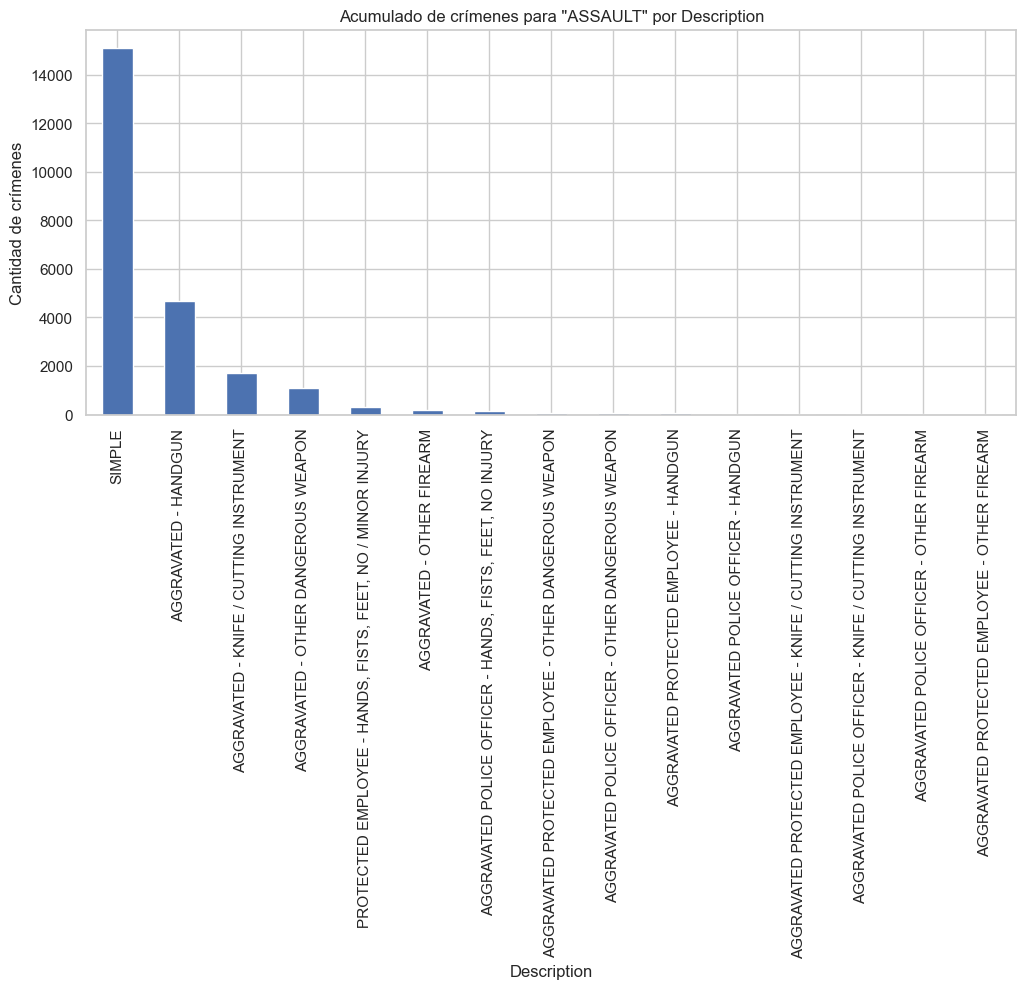


Crímenes con Descritpion para 'ASSAULT':
Description
SIMPLE                                                        15111
AGGRAVATED - HANDGUN                                           4678
AGGRAVATED - KNIFE / CUTTING INSTRUMENT                        1707
AGGRAVATED - OTHER DANGEROUS WEAPON                            1107
PROTECTED EMPLOYEE - HANDS, FISTS, FEET, NO / MINOR INJURY      316
AGGRAVATED - OTHER FIREARM                                      191
AGGRAVATED POLICE OFFICER - HANDS, FISTS, FEET, NO INJURY       142
AGGRAVATED PROTECTED EMPLOYEE - OTHER DANGEROUS WEAPON           52
AGGRAVATED POLICE OFFICER - OTHER DANGEROUS WEAPON               46
AGGRAVATED PROTECTED EMPLOYEE - HANDGUN                          44
AGGRAVATED POLICE OFFICER - HANDGUN                              39
AGGRAVATED PROTECTED EMPLOYEE - KNIFE / CUTTING INSTRUMENT       22
AGGRAVATED POLICE OFFICER - KNIFE / CUTTING INSTRUMENT           10
AGGRAVATED POLICE OFFICER - OTHER FIREARM                     

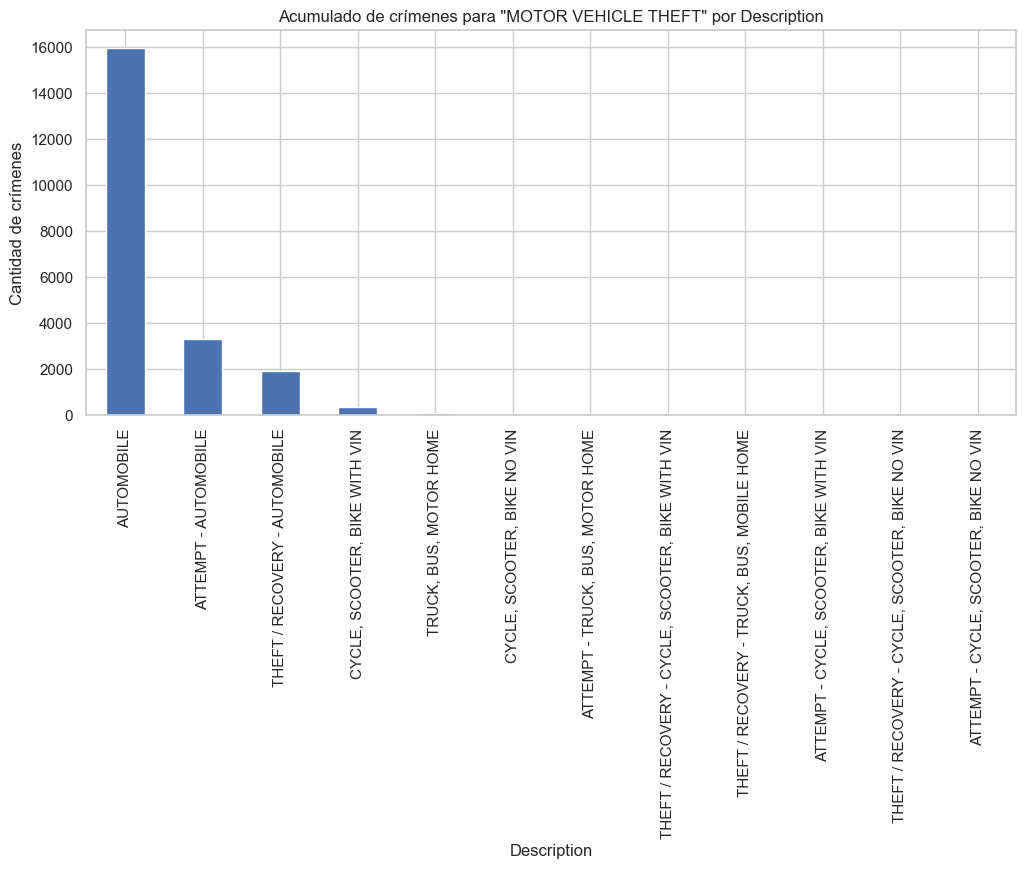


Crímenes con Descritpion para 'MOTOR VEHICLE THEFT':
Description
AUTOMOBILE                                          15943
ATTEMPT - AUTOMOBILE                                 3294
THEFT / RECOVERY - AUTOMOBILE                        1927
CYCLE, SCOOTER, BIKE WITH VIN                         343
TRUCK, BUS, MOTOR HOME                                 89
CYCLE, SCOOTER, BIKE NO VIN                            54
ATTEMPT - TRUCK, BUS, MOTOR HOME                       23
THEFT / RECOVERY - CYCLE, SCOOTER, BIKE WITH VIN       16
THEFT / RECOVERY - TRUCK, BUS, MOBILE HOME             14
ATTEMPT - CYCLE, SCOOTER, BIKE WITH VIN                 7
THEFT / RECOVERY - CYCLE, SCOOTER, BIKE NO VIN          2
ATTEMPT - CYCLE, SCOOTER, BIKE NO VIN                   1
Name: count, dtype: int64


In [87]:
for ptype in top5_types:
    subset = df_top5[df_top5['Primary Type'] == ptype]
    desc_counts = subset['Description'].value_counts().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 5))
    desc_counts.plot(kind='bar')
    plt.title(f'Acumulado de crímenes para "{ptype}" por Description')
    plt.xlabel('Description')
    plt.ylabel('Cantidad de crímenes')
    # plt.xticks(rotation=45)
    plt.show()

    print(f"\nCrímenes con Descritpion para '{ptype}':")
    print(desc_counts)

Text(0, 0.5, 'Location Description')

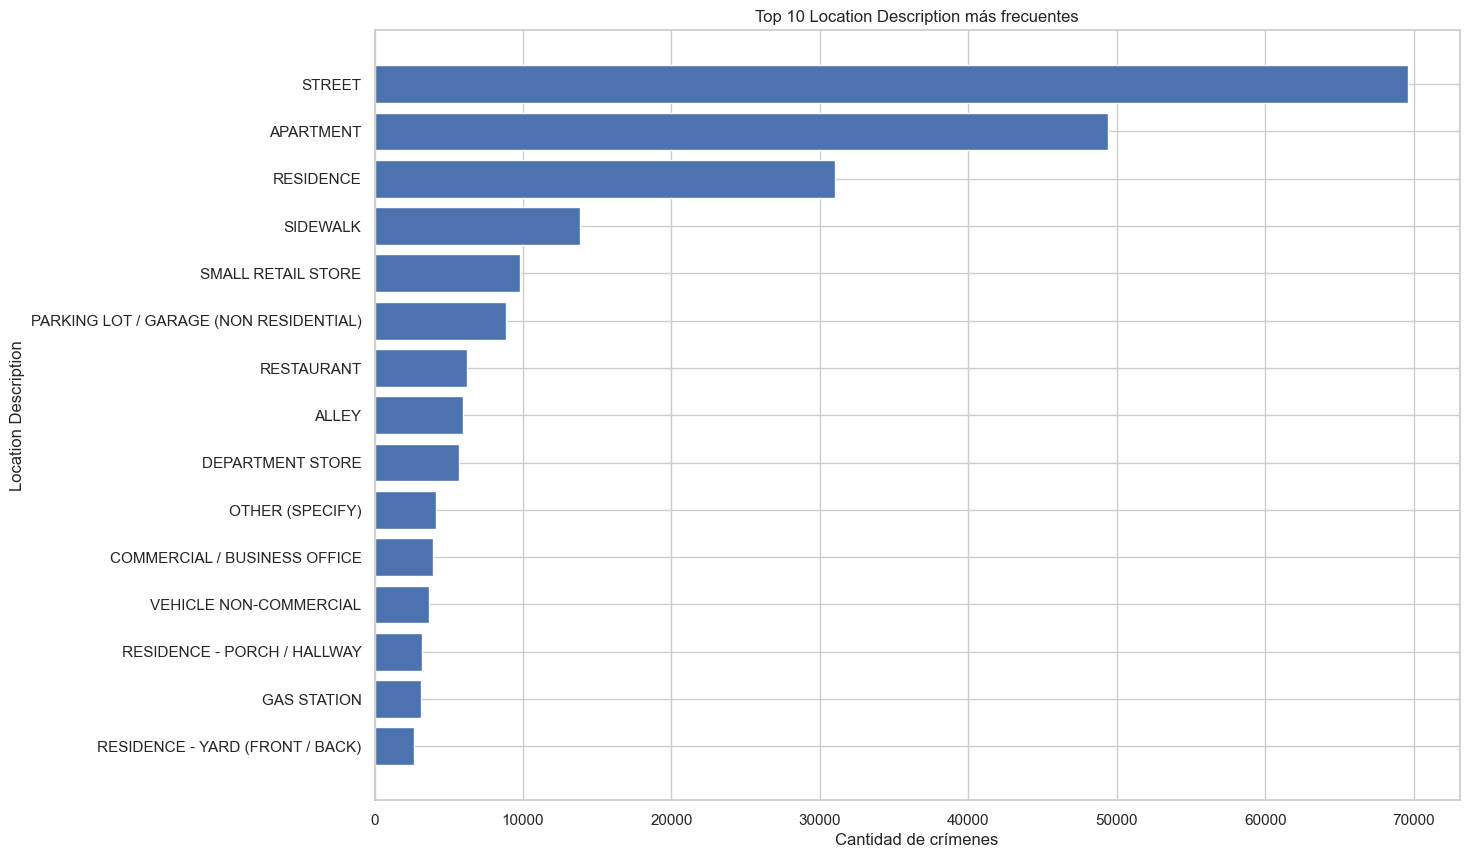

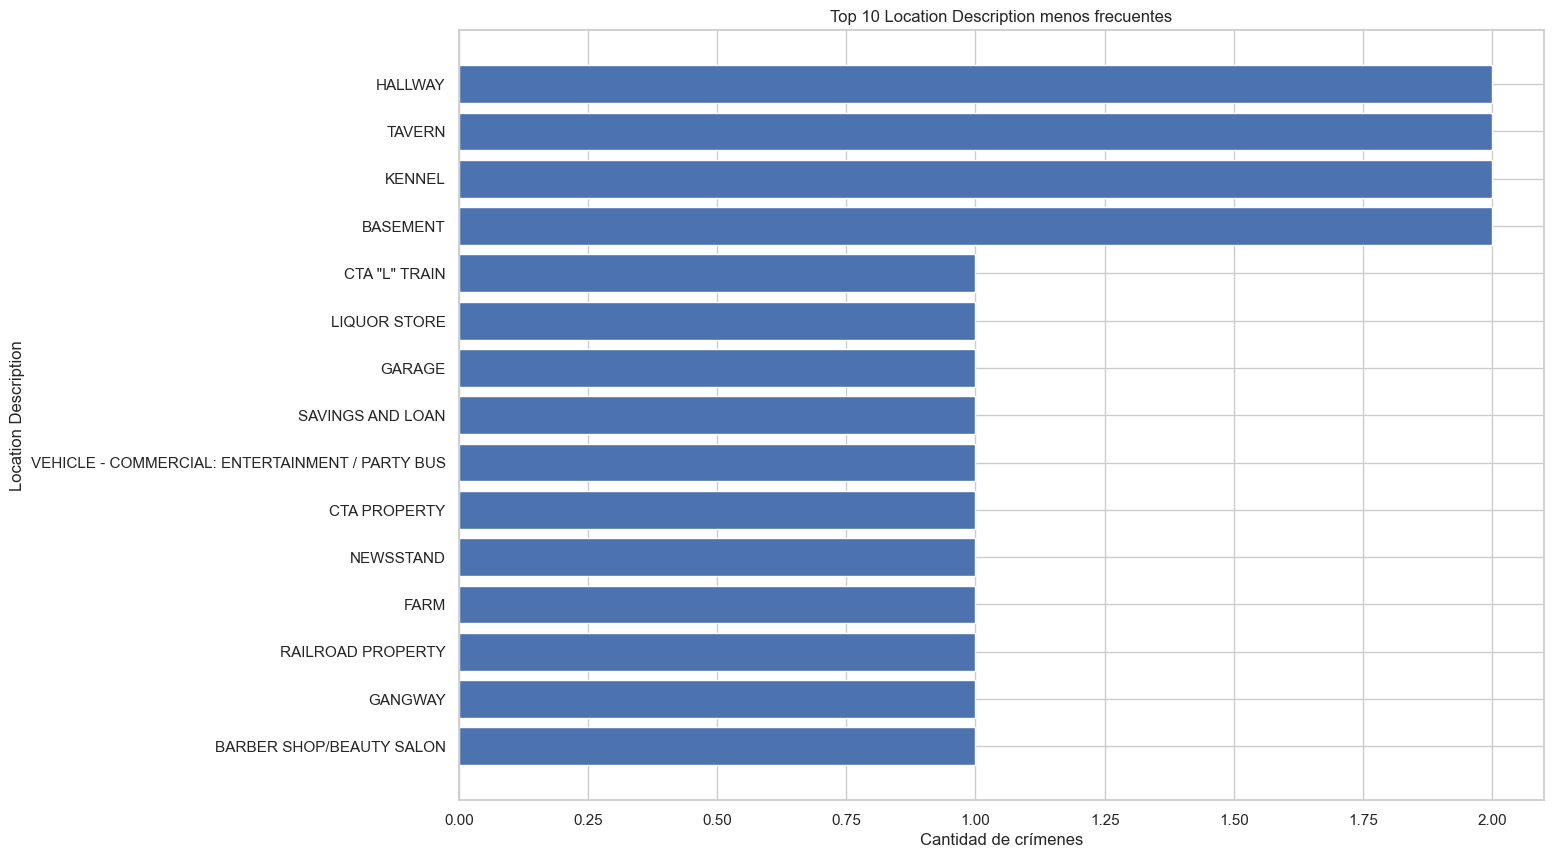

In [97]:
top_location = df['Location Description'].value_counts().nlargest(15)
bot_location = df['Location Description'].value_counts().nsmallest(15)

plt.figure(figsize=(14,10))
plt.barh(top_location.index[::-1], top_location.values[::-1])
plt.title("Top 10 Location Description más frecuentes")
plt.xlabel("Cantidad de crímenes")
plt.ylabel("Location Description")

plt.figure(figsize=(14,10))
plt.barh(bot_location.index, bot_location.values)
plt.title("Top 10 Location Description menos frecuentes")
plt.xlabel("Cantidad de crímenes")
plt.ylabel("Location Description")

### Visualización de situación legal de los crímenes

Text(0.5, 1.0, 'Proporción de crímenes domésticos')

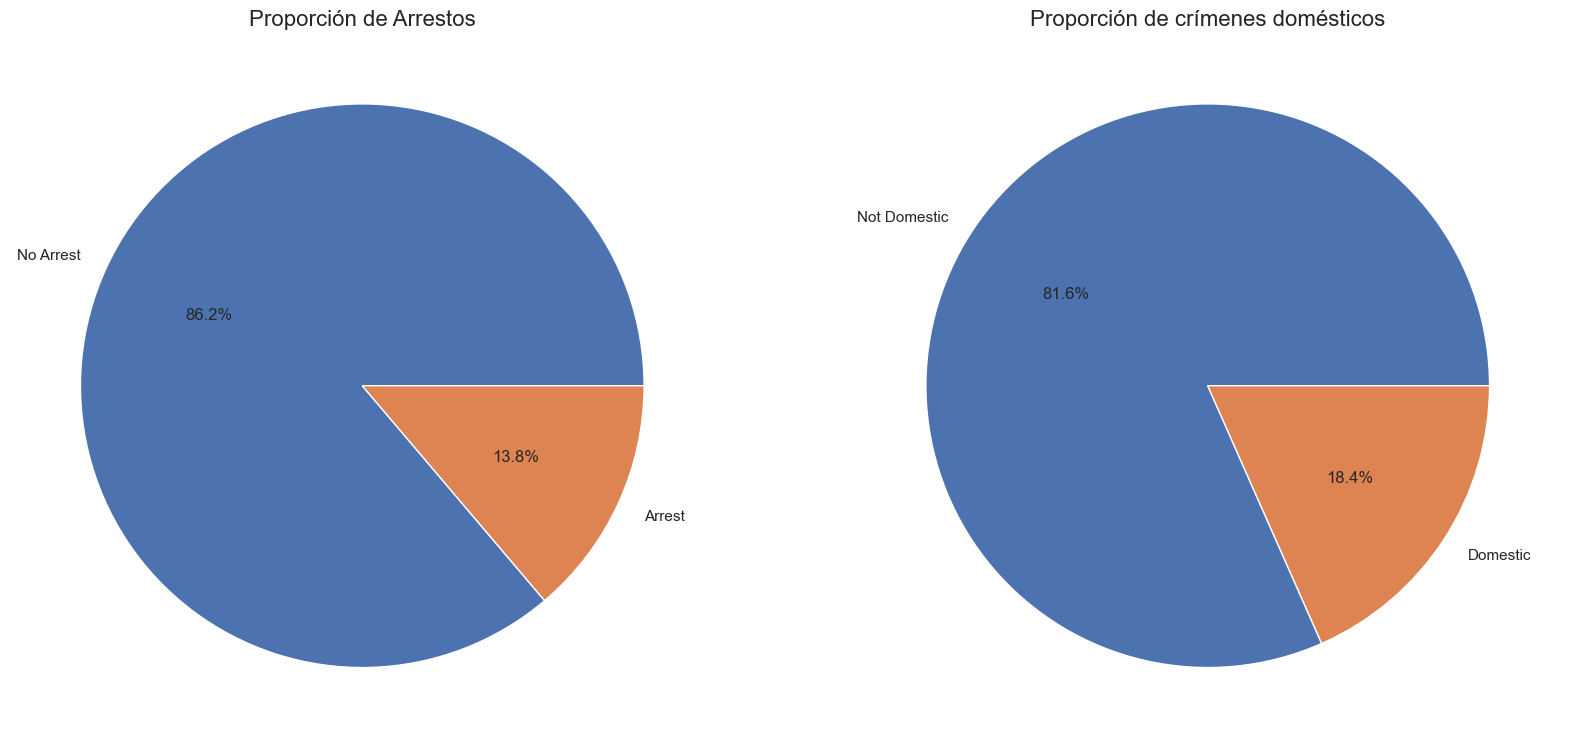

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].pie(df['Arrest'].value_counts(), labels=['No Arrest', 'Arrest'], autopct='%1.1f%%')
axs[0].set_title('Proporción de Arrestos', fontsize=16)

axs[1].pie(df['Domestic'].value_counts(), labels=['Not Domestic', 'Domestic'], autopct='%1.1f%%')
axs[1].set_title('Proporción de crímenes domésticos', fontsize=16)

A este punto se encuentra visualizada en gran parte la distribución de crímenes por cada una de las variables individuales. A partir de quí, el análisis debería empezar a combinar estas variables para definir una relación entre ellas.